# Molecular Weight

In questo file cercherò di aggiungere la variabile Molecular Weight al dataset di partenza. 

Partendo dal CAS number dei chemicals, usando la libreria *thermo*, estraggo il **molecular weight** dei chemicals. Già so che molti (circa 900) non verranno trovati, quindi passerò a *R* per cercare di trovare quelli che *thermo* non è riuscito a trovare. Alla fine farò un merge di quelli trovati da *thermo* e da *webchem* così da avere, almeno per i chemicals di cui si è riuscito a trovare lo SMILES, il peso molecolare.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thermo.identifiers import smiles
from thermo.identifiers import MW
from thermo.chemical import Chemical 

Si possono seguire due strade:

1) Applicare la funzione MW che calcola il Molecular Weight

2) Identificare tramite Chemical il composto dal CAS Number e poi cercare l'attributo (.MW)

### Usiamo (1)

Importiamo il dataset only_cas.csv che contiene i CAS number dei composti presi in considerazione

In [2]:
only_cas = pd.read_csv('dataset/only_cas.csv').drop(columns = 'Unnamed: 0')
only_cas.head()

,cas
0,10108-64-2
1,88-30-2
2,1397-94-0
3,25474-41-3
4,540-72-7


In [3]:
mw = pd.Series()

def find_MW(cas):
    try:
        out = MW(cas)
    except:
        out = 'NA'
    return out

for i in only_cas['cas']:
    mw = mw.append(pd.Series(find_MW(i)))

Conto il numero di CAS number di cui non si ha il molecular weight

In [4]:
na_mw_count = sum(mw == 'NA')
na_mw_count

962

Identifico gli NA: 
ricodifico prima gli indici

In [5]:
# na_mw_index 
mw_try = mw.copy()
mw_try = mw_try.reset_index().drop(columns = 'index')[0]
mw = mw_try

na_mw_index = mw[mw == 'NA'].index.tolist()

Unisco il dataset *only_cas* con i MW trovati: lo ridenomino cas_mw

In [6]:
only_cas['MolWeight'] = mw
cas_mw = only_cas.copy()
cas_mw.head()

,cas,MolWeight
0,10108-64-2,183.318
1,88-30-2,207.107
2,1397-94-0,548.625
3,25474-41-3,NA
4,540-72-7,81.0722


Creo un dataset di aiuto che mi permetta di spostarmi su R ed importare i cas che non hanno il MW.

In [7]:
cas_mw['cas'].loc[na_mw_index].to_csv('dataset_prova/cas_na_mw.csv', header = True)

Adesso vado su R e riporterò il codice scritto lì.

In [ ]:
'''
library(readr)
install.packages('webchem')
library('webchem')

cas_na_mw <- read_csv("C:/Users/Simone/Desktop/TESI -- lavoro/Script per tesi/dataset_prova/cas_na_mw.csv",
col_types = cols(X1 = col_skip()))

molWeight <- function(num){
  mw <- cir_query(num, representation = 'mw')
  return(mw[[1]])
}

cas_matrix <- as.matrix(cas_na_mw$cas)

mw <- apply(cas_matrix, 1, molWeight)

df <- as.data.frame(mw)

cas_find_mw <- data.frame(cas_na_mw, df)
write.csv(cas_find_mw, 'cas_find_mw.csv')

'''

Quindi importo il risultato ottenuto su R e faccio il merge dei risultati

In [8]:
temp = cas_mw.copy()
cas_find_mw = pd.read_csv('dataset_prova/cas_find_mw.csv').drop(columns = 'Unnamed: 0')
temp.head()
temp['MolWeight'].loc[na_mw_index] = cas_find_mw['mw'].values
print(sum(temp['MolWeight'].isnull()))

435


### Da controllare
Ancora 435 chemicals che non hanno trovato un MW... mi sembra che siano gli stessi che non hanno trovato rappresentazione SMILES.



In [9]:
cas_mw = temp.copy()
# esporto i risultati in cas_mw.csv
cas_mw.to_csv('dataset/cas_mw.csv')

Il numero di composti di cui si è trovato il peso molecolare è inferiore al numero di cas non tradotti in SMILES.

In [10]:
cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv').drop(columns = 'Unnamed: 0')
sum(cas_to_smiles['smiles'].isnull())

465

## rdkit
Un altro modo per fare la stessa cosa è usare **rdkit**

In [ ]:
import pandas as pd
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem import MolFromSmiles


cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv')

def molWeight(smiles):
    try:
        out = ExactMolWt(MolFromSmiles(smiles))
    except:
        out = 'NA'
    return out

mw = pd.Series()
for i in cas_to_smiles['smiles']:
    mw = mw.append(pd.Series(molWeight(i)))

sum(mw == 'NA')

# Adding new feature

Importo il dataset final su cui costruire i modelli e aggiungo la nuova feature trovata sotto il nome di **mol_weight**.

In [160]:
final_db = pd.read_csv('dataset/final_db_processed.csv')
use_db = final_db.copy()

use_db = use_db.merge(cas_mw, left_on = 'test_cas', right_on = 'cas').drop(columns = 'cas').rename(
    columns = {'MolWeight':'mol_weight'})
use_db

,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus,mol_weight
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,157.554
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,157.554
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio,138.124
3,100-01-6,idus,F,AQUA,48.0,35.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Leuciscus,138.124
4,100-01-6,latipes,A,S,24.0,68.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,Actinopterygii,Beloniformes,Adrianichthyidae,Oryzias,138.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23327,8015-35-8,hakonensis,F,S,48.0,1.3,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Cypriniformes,Cyprinidae,Tribolodon,476.52
23328,8015-35-8,hakonensis,F,S,96.0,1.3,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Cypriniformes,Cyprinidae,Tribolodon,476.52
23329,8015-35-8,masou,F,R,24.0,0.9,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,476.52
23330,8015-35-8,masou,F,R,48.0,0.7,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,476.52


Metto da parte questo risultato, in particolare lo metto nella cartella **dataset_prova**, sotto il nome di *db_molweigth.csv*

In [162]:
use_db.to_csv('dataset_prova/db_molweigth.csv')

# DA PROCESSARE

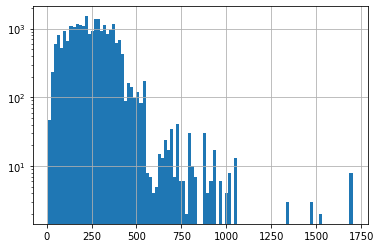

In [13]:
db = pd.read_csv('dataset_prova/db_molweigth.csv').drop(columns = 'Unnamed: 0')
db.mol_weight.hist(log = True, bins = 100)